# Relax Data Challenge

### Dependencies & data

In [1]:
# Dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

sns.set()
%matplotlib inline

In [2]:
# Usage data
usage_df = pd.read_csv('takehome_user_engagement.csv', parse_dates=['time_stamp'])
print(usage_df.info())
usage_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB
None


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1


In [3]:
# User data
user_df = pd.read_csv('takehome_users.csv', parse_dates=['creation_time'], encoding='latin-1')
print(user_df.info())
user_df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   object_id                   12000 non-null  int64         
 1   creation_time               12000 non-null  datetime64[ns]
 2   name                        12000 non-null  object        
 3   email                       12000 non-null  object        
 4   creation_source             12000 non-null  object        
 5   last_session_creation_time  8823 non-null   float64       
 6   opted_in_to_mailing_list    12000 non-null  int64         
 7   enabled_for_marketing_drip  12000 non-null  int64         
 8   org_id                      12000 non-null  int64         
 9   invited_by_user_id          6417 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(3)
memory usage: 937.6+ KB
None


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0


In [4]:
# Rename `object_id` to `user_id`
user_df.rename(columns={'object_id': 'user_id'}, inplace=True)

# Convert `last_session_creation_time` to datetime
user_df['last_session_creation_time'] = pd.to_datetime(user_df.last_session_creation_time, unit='s')
user_df.head(2)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0


### Label adopted users and count usage for each user

In [5]:
# Group visits by each user's weekly visits
weekly_usage_df = usage_df.groupby(['user_id', pd.Grouper(key='time_stamp', freq='7d')]).count()

# Filter for users who visited at least 3 times during any week
adopted_usage_df = weekly_usage_df[weekly_usage_df['visited'] >= 3]
adopted_users = adopted_usage_df.index.get_level_values(0).unique().values

print(len(adopted_users))
weekly_usage_df.head(2)

1445


,,visited
user_id,time_stamp,
1,2014-04-17,1
2,2013-11-14,1


In [6]:
# Create label for adopted users
# user_df['adopted_user'] = np.where(user_df['user_id'].isin(adopted_users), 1, 0)
user_df['adopted_user'] = user_df['user_id'].isin(adopted_users).astype(int)
assert user_df['adopted_user'].sum() == len(adopted_users) # confirm equal length
user_df.head(2)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,0


In [7]:
# Create a feature for the number of times each user logged in
usage_count_df = usage_df.groupby('user_id', as_index=False).sum()
user_df = user_df.merge(usage_count_df, on='user_id', how='left')
user_df['visited'] = user_df['visited'].fillna(0).astype(int) # fill missing with 0
user_df.head(2)

,user_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,visited
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0,1
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,0,14


### Split data

In [8]:
# Split features and label
X = user_df.drop('adopted_user', axis=1)
y = user_df['adopted_user'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=25, stratify=y)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((9000, 11), (3000, 11), (9000,), (3000,))

In [9]:
# Class (im)balance
y_train.value_counts()

0    7916
1    1084
Name: adopted_user, dtype: int64

### Resample data

In [10]:
def join_label_into_feats(X, y):
    df = X.merge(y, left_index=True, right_index=True)
    return df

# Test function
train = join_label_into_feats(X_train, y_train)
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9000 entries, 906 to 920
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   user_id                     9000 non-null   int64         
 1   creation_time               9000 non-null   datetime64[ns]
 2   name                        9000 non-null   object        
 3   email                       9000 non-null   object        
 4   creation_source             9000 non-null   object        
 5   last_session_creation_time  6603 non-null   datetime64[ns]
 6   opted_in_to_mailing_list    9000 non-null   int64         
 7   enabled_for_marketing_drip  9000 non-null   int64         
 8   org_id                      9000 non-null   int64         
 9   invited_by_user_id          4843 non-null   float64       
 10  visited                     9000 non-null   int64         
 11  adopted_user                9000 non-null   int64      

In [11]:
# Split train data by label
train0 = train[train['adopted_user'] == 0].copy()
train1 = train[train['adopted_user'] == 1].copy()
train.shape, train0.shape, train1.shape

((9000, 12), (7916, 12), (1084, 12))

In [12]:
# Upsample positive labels
train1_resampled = train1.sample(train0.shape[0], replace=True, random_state=10)

# Combine training data
train_resampled = pd.concat([train0, train1_resampled]).reset_index(drop=True)
train_resampled['adopted_user'].value_counts()

0    7916
1    7916
Name: adopted_user, dtype: int64

In [13]:
# Split features and label
X_train_resampled = train_resampled.drop('adopted_user', axis=1)
y_train_resampled = train_resampled['adopted_user'].copy()
X_train_resampled.shape, y_train_resampled.shape

((15832, 11), (15832,))

In [14]:
# Copy train set for preprocessing
X_train_preprocessed = X_train_resampled.copy()
y_train_preprocessed = y_train_resampled.copy()
X_train_preprocessed.shape, y_train_preprocessed.shape

((15832, 11), (15832,))

### Datetime EDA

In [15]:
# Create a feature for each user's first day of use
first_use = dict(usage_df.groupby('user_id')['time_stamp'].min()) # save for feature pipeline
X_train_preprocessed['first_use'] = X_train_preprocessed['user_id'].map(first_use)

# Create a feature for the number of days between account creation and first use
X_train_preprocessed['days_to_first_use'] = (X_train_preprocessed['first_use'] - X_train_preprocessed['creation_time']).dt.days
X_train_preprocessed['days_to_first_use'].fillna(999, inplace=True)
X_train_preprocessed['days_to_first_use'].value_counts()

0.0      6716
1.0      3401
999.0    2397
2.0      1741
3.0       751
4.0       406
5.0       229
6.0       122
7.0        43
8.0        13
9.0         6
10.0        3
12.0        2
14.0        1
11.0        1
Name: days_to_first_use, dtype: int64

In [16]:
# Create a feature for same day use
X_train_preprocessed['same_day_use'] = (X_train_preprocessed['days_to_first_use'] == 0).astype(int)
X_train_preprocessed['same_day_use'].value_counts()

0    9116
1    6716
Name: same_day_use, dtype: int64

In [17]:
# Join label into features
train_preprocessed = join_label_into_feats(X_train_preprocessed, y_train_preprocessed)

# User adoption rate of users who login within the first n days
ar_1d = train_preprocessed[train_preprocessed['days_to_first_use'] < 1]['adopted_user'].mean()
ar_7d = train_preprocessed[train_preprocessed['days_to_first_use'] < 7]['adopted_user'].mean()
ar_30d = train_preprocessed[train_preprocessed['days_to_first_use'] < 30]['adopted_user'].mean()

print(f'{ar_1d * 100:.2f}% of users who login within the same DAY as creating an account are adopted users.')
print(f'{ar_7d * 100:.2f}% of users who login within the same WEEK as creating an account are adopted users.')
print(f'{ar_30d * 100:.2f}% of users who login within the same MONTH as creating an account are adopted users.')

59.96% of users who login within the same DAY as creating an account are adopted users.
59.01% of users who login within the same WEEK as creating an account are adopted users.
58.92% of users who login within the same MONTH as creating an account are adopted users.


,creation_month,adoption_rate
0,2012-05,0.500000
1,2012-06,0.549912
2,2012-07,0.564189
3,2012-08,0.573055
4,2012-09,0.572131
5,2012-10,0.541667
6,2012-11,0.508380
7,2012-12,0.566102
8,2013-01,0.504078
9,2013-02,0.574603


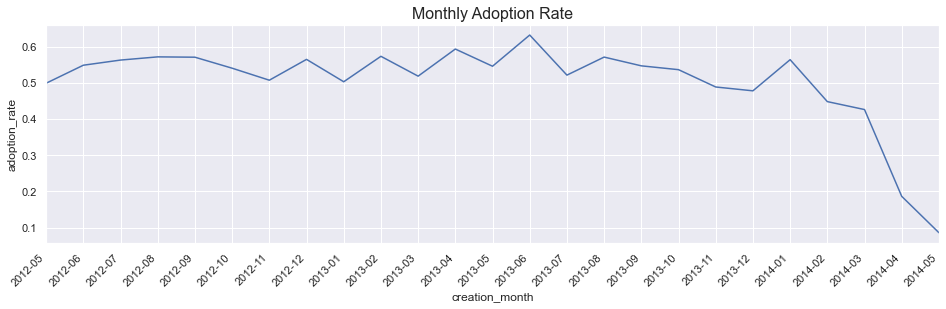

In [18]:
# Check adoption rate of each signup month
monthly_adoption_df = train_preprocessed.groupby(pd.Grouper(key='creation_time', freq='M'))[['adopted_user']].mean().reset_index()
monthly_adoption_df['creation_time'] = monthly_adoption_df['creation_time'].dt.strftime('%Y-%m')
monthly_adoption_df.columns = ['creation_month', 'adoption_rate']

# Plot monthly adoption
plt.figure(figsize=(16, 4))
sns.lineplot(data=monthly_adoption_df, x='creation_month', y='adoption_rate')
plt.title('Monthly Adoption Rate', fontsize=16)
plt.xticks(ticks=range(monthly_adoption_df.shape[0]), labels=monthly_adoption_df['creation_month'], rotation=45, ha='right')
plt.xlim((0, monthly_adoption_df.shape[0] - 1))

monthly_adoption_df

### Categorical EDA

In [19]:
# Simplify `invited_by_user_id` to a boolean feature that indicates whether the user was invited
X_train_preprocessed['invited'] = (X_train_preprocessed['invited_by_user_id'].notnull()).astype(int)

# Extract email domain
X_train_preprocessed['email_domain'] = X_train_preprocessed['email'].str.split('@', expand=True)[1]
email_domains = X_train_preprocessed['email_domain'].value_counts()
email_domains[email_domains > 10]

gmail.com         4923
yahoo.com         2989
jourrapide.com    1689
hotmail.com       1673
gustr.com         1518
cuvox.de          1474
ldguj.com           15
kbxlm.com           14
fgnyh.com           14
mumdc.com           14
nxydr.com           13
xxxue.com           13
qcnhy.com           12
mykch.com           12
wydvs.com           12
bikch.com           11
lvwyf.com           11
Name: email_domain, dtype: int64

In [20]:
# Group rare domains into a single category
common_domains = email_domains[email_domains > 20].index.values # save for feature pipeline
# X_train_preprocessed['email_domain'] = X_train_preprocessed['email_domain'].apply(lambda d: d if d in common_domains else 'other')
X_train_preprocessed.loc[~X_train_preprocessed['email_domain'].isin(common_domains), 'email_domain'] = 'other'
X_train_preprocessed['email_domain'].value_counts()

gmail.com         4923
yahoo.com         2989
jourrapide.com    1689
hotmail.com       1673
other             1566
gustr.com         1518
cuvox.de          1474
Name: email_domain, dtype: int64

,adopted_user,visited
email_domain,,
cuvox.de,0.449118,57.508141
gmail.com,0.529961,75.912452
gustr.com,0.469697,60.678524
hotmail.com,0.575613,76.523610
jourrapide.com,0.495560,74.320900
other,0.498084,70.102810
yahoo.com,0.452325,54.745400


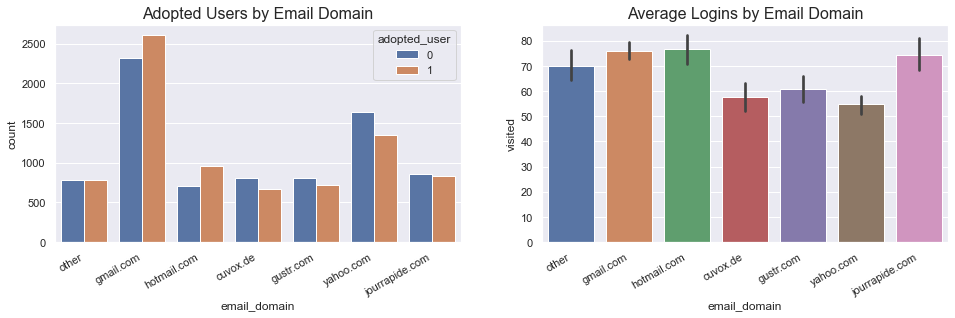

In [21]:
# Join label into features
train_preprocessed = join_label_into_feats(X_train_preprocessed, y_train_preprocessed)

# User adoption and average logins by email domain
fig1, ax1 = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train_preprocessed, x='email_domain', hue='adopted_user', ax=ax1[0])
sns.barplot(data=train_preprocessed, x='email_domain', y='visited', ax=ax1[1])
ax1[0].set_title('Adopted Users by Email Domain', fontsize=16)
ax1[1].set_title('Average Logins by Email Domain', fontsize=16)
ax1[0].set_xticklabels(ax1[0].get_xticklabels(), rotation=30, ha='right')
ax1[1].set_xticklabels(ax1[1].get_xticklabels(), rotation=30, ha='right')

# User adoption rate and average logins by email domain
train_preprocessed.groupby('email_domain')[['adopted_user', 'visited']].mean()

,adopted_user,visited
creation_source,,
GUEST_INVITE,0.152566,21.634767
ORG_INVITE,0.115891,16.476493
PERSONAL_PROJECTS,0.067740,9.105637
SIGNUP,0.130810,17.989938
SIGNUP_GOOGLE_AUTH,0.148736,24.738628


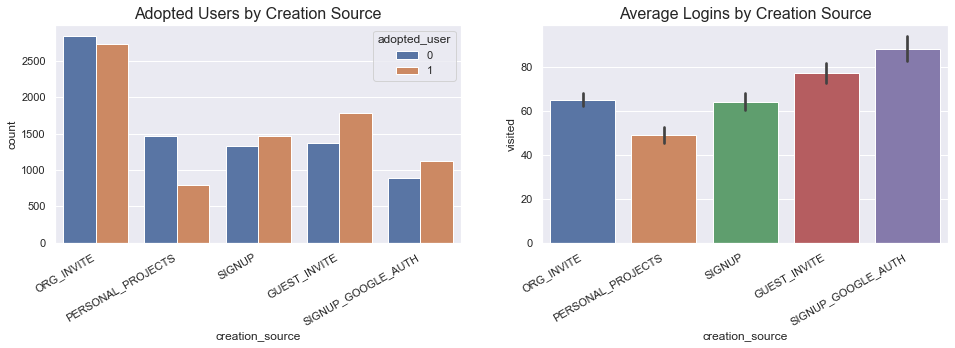

In [22]:
# User adoption and average logins by creation source
fig2, ax2 = plt.subplots(1, 2, figsize=(16, 4))
sns.countplot(data=train_preprocessed, x='creation_source', hue='adopted_user', ax=ax2[0])
sns.barplot(data=train_preprocessed, x='creation_source', y='visited', ax=ax2[1])
ax2[0].set_title('Adopted Users by Creation Source', fontsize=16)
ax2[1].set_title('Average Logins by Creation Source', fontsize=16)
ax2[0].set_xticklabels(ax2[0].get_xticklabels(), rotation=30, ha='right')
ax2[1].set_xticklabels(ax2[1].get_xticklabels(), rotation=30, ha='right')

# User adoption rate and average logins by creation source
user_df.groupby('creation_source')[['adopted_user', 'visited']].mean()

In [23]:
# Group organizations by size
org_sizes = X_train_preprocessed['org_id'].value_counts()
pd.qcut(org_sizes, 9)

0      (60.778, 266.0]
1      (60.778, 266.0]
3      (60.778, 266.0]
2      (60.778, 266.0]
7      (60.778, 266.0]
            ...       
355      (0.999, 14.0]
386      (0.999, 14.0]
294      (0.999, 14.0]
410      (0.999, 14.0]
416      (0.999, 14.0]
Name: org_id, Length: 417, dtype: category
Categories (9, interval[float64, right]): [(0.999, 14.0] < (14.0, 20.0] < (20.0, 24.0] < (24.0, 28.0] ... (34.0, 39.0] < (39.0, 46.0] < (46.0, 60.778] < (60.778, 266.0]]

In [24]:
# Group organizations into 9 bins depending on size
bin_size = 9
org_cats = pd.qcut(org_sizes, bin_size, labels=range(bin_size)).to_dict() # save for feature pipeline
X_train_preprocessed['org_size'] = X_train_preprocessed['org_id'].map(org_cats)

# Group categories 0 and 1
X_train_preprocessed.loc[X_train_preprocessed['org_size'] == 0, 'org_size'] = 1
X_train_preprocessed['org_size'].value_counts()

8    4859
7    2406
5    1738
6    1711
4    1439
1    1395
3    1353
2     931
Name: org_size, dtype: int64

,adopted_user,visited
org_size,,
1,0.278853,36.142652
2,0.419979,68.096670
3,0.473023,55.942350
4,0.574010,75.699097
5,0.592060,85.418297
6,0.541204,81.595558
7,0.541563,76.498753
8,0.496398,63.181725


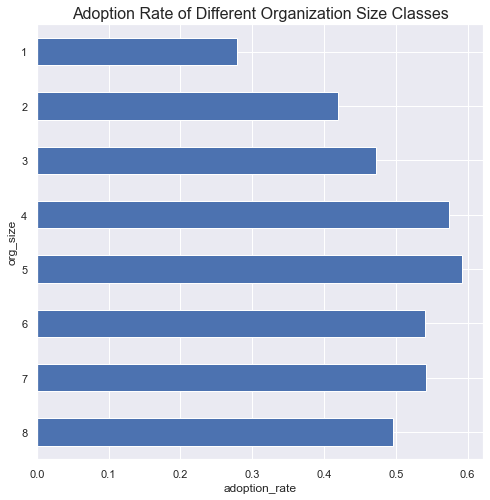

In [25]:
# Join label into features
train_preprocessed = join_label_into_feats(X_train_preprocessed, y_train_preprocessed)

# Adoption rate by organization
org_adoption_df = train_preprocessed.groupby('org_size')[['adopted_user', 'visited']].mean()
org_adoption_df['adopted_user'].sort_index(ascending=False).plot(kind='barh', figsize=(8, 8))
plt.title('Adoption Rate of Different Organization Size Classes', fontsize=16)
plt.xlabel('adoption_rate')

org_adoption_df

### Encode categorical variables

In [26]:
# Create an email_domain-to-adoption_rate mapping
dom_ar = train_preprocessed.groupby('email_domain')['adopted_user'].mean().to_dict() # save for feature pipeline
print(dom_ar)

# Encode `email_domain` with their adoption rate
X_train_preprocessed['email_enc'] = X_train_preprocessed['email_domain'].map(dom_ar)
X_train_preprocessed['email_enc'].value_counts()

{'cuvox.de': 0.4491180461329715, 'gmail.com': 0.5299614056469633, 'gustr.com': 0.4696969696969697, 'hotmail.com': 0.5756126718469815, 'jourrapide.com': 0.4955595026642984, 'other': 0.49808429118773945, 'yahoo.com': 0.4523251923720308}


0.529961    4923
0.452325    2989
0.495560    1689
0.575613    1673
0.498084    1566
0.469697    1518
0.449118    1474
Name: email_enc, dtype: int64

In [27]:
# Create a creation_source-to-adoption_rate mapping
src_ar = train_preprocessed.groupby('creation_source')['adopted_user'].mean().to_dict() # save for feature pipeline
print(src_ar)

# Encode `creation_source` with their adoption rate
X_train_preprocessed['creation_enc'] = X_train_preprocessed['creation_source'].map(src_ar)
X_train_preprocessed['creation_enc'].value_counts()

{'GUEST_INVITE': 0.5648879065361541, 'ORG_INVITE': 0.48997852541159626, 'PERSONAL_PROJECTS': 0.35143487858719646, 'SIGNUP': 0.5246252676659529, 'SIGNUP_GOOGLE_AUTH': 0.5587064676616915}


0.489979    5588
0.564888    3167
0.524625    2802
0.351435    2265
0.558706    2010
Name: creation_enc, dtype: int64

In [28]:
# Create an organization-to-adoption_rate mapping
org_ar = train_preprocessed.groupby('org_size')['adopted_user'].mean().to_dict() # save for feature pipeline
print(org_ar)

# Encode `org_id` with their adoption rate
X_train_preprocessed['org_enc'] = X_train_preprocessed['org_size'].map(org_ar)
X_train_preprocessed['org_enc'].value_counts()

{1: 0.27885304659498206, 2: 0.41997851772287864, 3: 0.4730229120473023, 4: 0.5740097289784573, 5: 0.5920598388952819, 6: 0.5412039742840444, 7: 0.5415627597672485, 8: 0.4963984358921589}


0.496398    4859
0.541563    2406
0.592060    1738
0.541204    1711
0.574010    1439
0.278853    1395
0.473023    1353
0.419979     931
Name: org_enc, dtype: int64

### Select features

In [29]:
# Select features for train set
selected_cols = ['email_enc', 'creation_enc', 'org_enc', 'invited', 'same_day_use', 
                 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']
X_train_preprocessed = X_train_preprocessed[selected_cols].copy()
X_train_preprocessed.head(2)

,email_enc,creation_enc,org_enc,invited,same_day_use,opted_in_to_mailing_list,enabled_for_marketing_drip
0,0.498084,0.489979,0.57401,1,0,0,0
1,0.529961,0.489979,0.57401,1,0,1,1


### Feature pipeline

In [30]:
def feature_pipeline(data, first_use_mapping, domain_list, domain_encoding, 
                     org_bins, org_encoding, source_encoding, selected_features):
    
    """
    Feature pipeline:
    - email_enc
        > email_domain (extract domain from email, rare-category encode email_domain w/ `common_domains`) 
        > email_enc (mean-target encode email_domain w/ `dom_ar`)
    - creation_enc (mean-target encode creation_source w/ `src_ar`)
    - org_enc
        > org_size (bin org_id value counts w/ `org_cats`, combine bins 0 and 1)
        > org_enc (mean-target encode org_size w/ `org_ar`)
    - invited (binary encode invited_by_user_id)
    - same_day_use
        > first_use (encode user_id w/ `first_use`) 
        > days_to_first_use (diff first_use and creation_time in days, fill na w/ 999) 
        > same_day_use (binary encode days_to_first_use)
    - select features: 'email_enc', 'creation_enc', 'org_enc', 'invited', 'same_day_use', 
                       'opted_in_to_mailing_list', 'enabled_for_marketing_drip'
    """
    
    data = data.copy()
    
    # Encode email domains with their adoption rates
    data['email_domain'] = data['email'].str.split('@', expand=True)[1] # email domain
    data.loc[~data['email_domain'].isin(common_domains), 'email_domain'] = 'other' # encode rare categories
    data['email_enc'] = data['email_domain'].map(domain_encoding)

    # Encode creation sources with their adoption rates
    data['creation_enc'] = data['creation_source'].map(source_encoding)
    
    # Encode organization sizes with their adoption rates
    data['org_size'] = data['org_id'].map(org_bins) # group organizations into size bins
    data.loc[data['org_size'] == 0, 'org_size'] = 1 # group bins 0 and 1
    data['org_enc'] = data['org_size'].map(org_encoding)
    
    # Create a binary feature for invited
    data['invited'] = (data['invited_by_user_id'].notnull()).astype(int)
    
    # Create binary feature for same day use
    data['first_use'] = data['user_id'].map(first_use_mapping) # first day of use
    data['days_to_first_use'] = (data['first_use'] - data['creation_time']).dt.days # number of days to first use
    data['days_to_first_use'].fillna(999, inplace=True)
    data['same_day_use'] = (data['days_to_first_use'] == 0).astype(int)
    
    # Select features
    data = data[selected_features].copy()
    
    return data


# Test pipeline
X_train_pipelined = feature_pipeline(X_train_resampled, first_use, common_domains, dom_ar, org_cats, org_ar, src_ar, selected_cols)
X_train_pipelined.equals(X_train_preprocessed)

True

In [31]:
# Preprocess test set
X_test_preprocessed = feature_pipeline(X_test, first_use, common_domains, dom_ar, org_cats, org_ar, src_ar, selected_cols)
y_test_preprocessed = y_test.copy()
X_test_preprocessed.shape, y_test_preprocessed.shape

((3000, 7), (3000,))

### Modeling 1 - selected feature set

In [32]:
# Preprocessed train set
X_train_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15832 entries, 0 to 15831
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   email_enc                   15832 non-null  float64
 1   creation_enc                15832 non-null  float64
 2   org_enc                     15832 non-null  float64
 3   invited                     15832 non-null  int64  
 4   same_day_use                15832 non-null  int64  
 5   opted_in_to_mailing_list    15832 non-null  int64  
 6   enabled_for_marketing_drip  15832 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 865.9 KB


In [33]:
# Preprocessed test set
X_test_preprocessed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 7241 to 2089
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   email_enc                   3000 non-null   float64
 1   creation_enc                3000 non-null   float64
 2   org_enc                     3000 non-null   float64
 3   invited                     3000 non-null   int64  
 4   same_day_use                3000 non-null   int64  
 5   opted_in_to_mailing_list    3000 non-null   int64  
 6   enabled_for_marketing_drip  3000 non-null   int64  
dtypes: float64(3), int64(4)
memory usage: 187.5 KB


In [34]:
def grid_search(estimator, params, X_train, y_train, scoring='roc_auc', cv=4, n_jobs=8):
    gs = GridSearchCV(estimator, params, scoring=scoring, cv=cv, n_jobs=n_jobs)
    gs.fit(X_train, y_train)
    print('Best score:', gs.best_score_)
    print('Best params:', gs.best_params_)
    return gs


# Test function
gs = grid_search(LogisticRegression(), dict(random_state = [1, 2]), X_train_preprocessed, y_train_preprocessed)
gs

Best score: 0.6502486887967928
Best params: {'random_state': 1}


GridSearchCV(cv=4, estimator=LogisticRegression(), n_jobs=8,
             param_grid={'random_state': [1, 2]}, scoring='roc_auc')

In [35]:
def train_and_predict(estimator, y_train, X_train, X_test):
    model = estimator.fit(X_train, y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    return model, pred_train, pred_test


# Test function
model, pred_train, pred_test = train_and_predict(LogisticRegression(), y_train_preprocessed, X_train_preprocessed, X_test_preprocessed)
model, pred_train, pred_test

(LogisticRegression(),
 array([0, 1, 0, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 1, 1, 0]))

In [36]:
def print_metrics(y_true, y_pred):
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('ROC AUC:', roc_auc_score(y_true, y_pred))
    print('Confusion matrix:\n', confusion_matrix(y_true, y_pred))


# Test function
print_metrics(y_train_preprocessed, pred_train)

Accuracy: 0.6063668519454269
ROC AUC: 0.606366851945427
Confusion matrix:
 [[4817 3099]
 [3133 4783]]


In [37]:
def evaluate_model(estimator, X_train, X_test, y_train, y_test, params=None, scoring='roc_auc', cv=4, n_jobs=8):
    
    # Grid search
    if params is not None:
        gs = grid_search(estimator, params, X_train, y_train, scoring, cv, n_jobs)
        estimator = gs.best_estimator_
        
    # Train model and make predictions
    model, pred_train, pred_test = train_and_predict(estimator, y_train, X_train, X_test)
    
    # Print metrics
    print('Train')
    print_metrics(y_train, pred_train)
    print('\nTest')
    print_metrics(y_test, pred_test)
    
    return model, pred_train, pred_test


# Test function
evaluate_model(model, X_train_preprocessed, X_test_preprocessed, y_train_preprocessed, y_test_preprocessed)

Train
Accuracy: 0.6063668519454269
ROC AUC: 0.606366851945427
Confusion matrix:
 [[4817 3099]
 [3133 4783]]

Test
Accuracy: 0.5956666666666667
ROC AUC: 0.5597567491253612
Confusion matrix:
 [[1602 1037]
 [ 176  185]]


(LogisticRegression(),
 array([0, 1, 0, ..., 1, 1, 1]),
 array([0, 0, 0, ..., 1, 1, 0]))

In [ ]:
def get_feature_importances(X_train, lr_model, dt_model):
    pass


# Test function
get_feature_importances(X_train_preprocessed, model, model)

In [38]:
# Logistic regression
lr = LogisticRegression(max_iter=1e4, random_state=0)
lr, lr_pred_train, lr_pred_test = evaluate_model(lr, X_train_preprocessed, X_test_preprocessed, 
                                                 y_train_preprocessed, y_test_preprocessed)

Train
Accuracy: 0.6063668519454269
ROC AUC: 0.606366851945427
Confusion matrix:
 [[4817 3099]
 [3133 4783]]

Test
Accuracy: 0.5956666666666667
ROC AUC: 0.5597567491253612
Confusion matrix:
 [[1602 1037]
 [ 176  185]]


In [39]:
# Decision tree
dt = DecisionTreeClassifier(random_state=0)
params = {'max_depth': range(2, 22, 2), 'min_samples_split': range(2, 22, 2), 'min_samples_leaf': range(2, 22, 2)}
dt, dt_pred_train, dt_pred_test = evaluate_model(dt, X_train_preprocessed, X_test_preprocessed, 
                                                 y_train_preprocessed, y_test_preprocessed, params)

Best score: 0.7701332025683522
Best params: {'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 2}
Train
Accuracy: 0.7355356240525518
ROC AUC: 0.7355356240525519
Confusion matrix:
 [[5341 2575]
 [1612 6304]]

Test
Accuracy: 0.5963333333333334
ROC AUC: 0.508725919223579
Confusion matrix:
 [[1647  992]
 [ 219  142]]


In [40]:
# Feature coefficients
pd.DataFrame(np.array([X_train_preprocessed.columns.values, lr.coef_[0], dt.feature_importances_]).T, 
             columns=['feature', 'lr_coef', 'dt_coef'])

,feature,lr_coef,dt_coef
0,email_enc,3.082503,0.217949
1,creation_enc,3.188237,0.146783
2,org_enc,3.920009,0.275727
3,invited,0.025881,0.045791
4,same_day_use,0.64097,0.09001
5,opted_in_to_mailing_list,0.02863,0.116842
6,enabled_for_marketing_drip,-0.030119,0.106899


### Modeling 2 - binary feature subset

In [41]:
# Filter for binary features
X_train_bin = X_train_preprocessed[['invited', 'same_day_use', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']].copy()
X_test_bin = X_test_preprocessed[['invited', 'same_day_use', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']].copy()
X_train_bin.shape, X_test_bin.shape

((15832, 4), (3000, 4))

In [42]:
# Logistic regression
lr_bin = LogisticRegression(max_iter=1e4, random_state=0)
lr_bin, lr_bin_pred_train, lr_bin_pred_test = evaluate_model(lr_bin, X_train_bin, X_test_bin, 
                                                             y_train_preprocessed, y_test_preprocessed)

Train
Accuracy: 0.5845123799898939
ROC AUC: 0.5845123799898939
Confusion matrix:
 [[5227 2689]
 [3889 4027]]

Test
Accuracy: 0.6433333333333333
ROC AUC: 0.6083707103861846
Confusion matrix:
 [[1727  912]
 [ 158  203]]


In [43]:
# Decision tree
dt_bin = DecisionTreeClassifier(random_state=0)
params_bin = {'max_depth': range(2, 22, 2), 'min_samples_split': range(2, 22, 2), 'min_samples_leaf': range(2, 22, 2)}
dt_bin, dt_bin_pred_train, dt_bin_pred_test = evaluate_model(dt_bin, X_train_bin, X_test_bin, 
                                                             y_train_preprocessed, y_test_preprocessed, params_bin)

Best score: 0.5959228991321457
Best params: {'max_depth': 4, 'min_samples_leaf': 2, 'min_samples_split': 2}
Train
Accuracy: 0.5849545224861041
ROC AUC: 0.5849545224861041
Confusion matrix:
 [[5140 2776]
 [3795 4121]]

Test
Accuracy: 0.6363333333333333
ROC AUC: 0.6079786580789542
Confusion matrix:
 [[1703  936]
 [ 155  206]]


In [44]:
# Feature coefficients
pd.DataFrame(np.array([X_train_bin.columns.values, lr_bin.coef_[0], dt_bin.feature_importances_]).T, 
             columns=['feature', 'lr_coef', 'dt_coef'])

,feature,lr_coef,dt_coef
0,invited,0.132081,0.036326
1,same_day_use,0.695032,0.88803
2,opted_in_to_mailing_list,0.017394,0.039981
3,enabled_for_marketing_drip,-0.014331,0.035664


### Modeling 3 - encoded feature subset

In [45]:
# Filter for encoded features
X_train_enc = X_train_preprocessed[['email_enc', 'creation_enc', 'org_enc']].copy()
X_test_enc = X_test_preprocessed[['email_enc', 'creation_enc', 'org_enc']].copy()
X_train_enc.shape, X_test_enc.shape

((15832, 3), (3000, 3))

In [46]:
# Logistic regression
lr_enc = LogisticRegression(max_iter=1e4, random_state=0)
lr_enc, lr_enc_pred_train, lr_enc_pred_test = evaluate_model(lr_enc, X_train_enc, X_test_enc, 
                                                             y_train_preprocessed, y_test_preprocessed)

Train
Accuracy: 0.5821121778676099
ROC AUC: 0.5821121778676099
Confusion matrix:
 [[4070 3846]
 [2770 5146]]

Test
Accuracy: 0.5313333333333333
ROC AUC: 0.5279721711090515
Confusion matrix:
 [[1405 1234]
 [ 172  189]]


In [47]:
# Decision tree
dt_enc = DecisionTreeClassifier(random_state=0)
params_enc = {'max_depth': range(2, 22, 2), 'min_samples_split': range(2, 22, 2), 'min_samples_leaf': range(2, 22, 2)}
dt_enc, dt_enc_pred_train, dt_enc_pred_test = evaluate_model(dt_enc, X_train_enc, X_test_enc, 
                                                             y_train_preprocessed, y_test_preprocessed, params_enc)

Best score: 0.6514707804866715
Best params: {'max_depth': 14, 'min_samples_leaf': 2, 'min_samples_split': 2}
Train
Accuracy: 0.620199595755432
ROC AUC: 0.6201995957554319
Confusion matrix:
 [[4567 3349]
 [2664 5252]]

Test
Accuracy: 0.5583333333333333
ROC AUC: 0.5253852556842337
Confusion matrix:
 [[1501 1138]
 [ 187  174]]


In [48]:
# Feature coefficients
pd.DataFrame(np.array([X_train_enc.columns.values, lr_enc.coef_[0], dt_enc.feature_importances_]).T, 
             columns=['feature', 'lr_coef', 'dt_coef'])

,feature,lr_coef,dt_coef
0,email_enc,2.928309,0.313169
1,creation_enc,3.692348,0.258793
2,org_enc,4.004695,0.428038
